# 🤗 프로젝트 : 커스텀 프로젝트 직접 만들기

klue/bert-base 를 사용하여 NSMC task를 수행하라.
> - https://huggingface.co/klue/bert-base
> - https://github.com/e9t/nsmc

### 평가항목 1:

- sentence piece를 사용해 토크나이징 한 후
- klue/bert-base를 특성추출기로 사용해 base-line 성능을 기록했다.

### 평가항목 2: 

- 적절한 전처리와 fine-tuning을 통해 val_acc를 90% 이상 달성했다.

### 평가항목 3:

- 클래스 분포를 살펴보고 Bucketing을 수행하여 어떤 효과를 기대할 수 있는지 예상한 결과를 기록했다.

- Bucketing을 수행하여 finetuning 시 연산속도와 모델성능간의 trade-off관계가 발생하는지 여부를 확인하고 분석한 결과를 제시하였다.

## Step 1 : preprocessing

In [8]:
# excel 파일에 outline 같이 짜기
# ! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# ! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2023-02-13 02:40:36--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.06s   

2023-02-13 02:40:36 (78.9 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]



In [9]:
# 데이터 다운로드 되었는지 확인
!ls rating*

ratings_test.txt  ratings_train.txt


In [128]:
# pandas library 확인
import pandas as pd
import numpy as np

In [129]:
# pandas 로 다운로드 파일 데이터프레임 생성
train = pd.read_table('./ratings_train.txt')
test = pd.read_table('./ratings_test.txt')

In [130]:
train_cp = train.copy()
test_cp = test.copy()

In [131]:
idx = train_cp['document'].duplicated()

In [132]:
# 데이터 확인
train.info() # null-value 확인 5개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [133]:
# 데이터 확인
test.info() # null-value 확인 3개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [134]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [135]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [136]:
# document length
train['doc_len'] = train['document'].apply(lambda x: len(str(x)))
test['doc_len'] = test['document'].apply(lambda x: len(str(x)))

<AxesSubplot:>

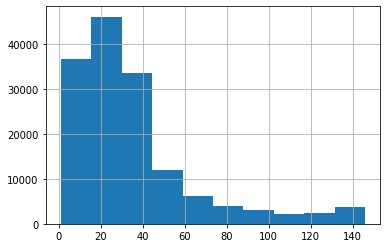

In [137]:
train.doc_len.hist()

<AxesSubplot:>

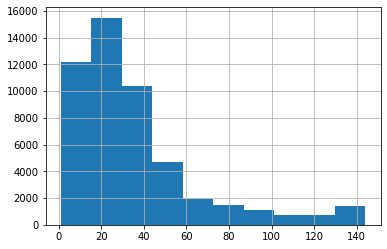

In [138]:
test.doc_len.hist()

In [139]:
# null 값 있는 자료 삭제
n_idx_tr = train.loc[train['document'].isnull()].index
train.drop(index=n_idx_tr, inplace=True)
train.loc[train['document'].isnull()]

,id,document,label,doc_len


In [140]:
print(train['doc_len'].max())

146


In [141]:
# null 값 있는 자료 삭제
n_idx_ts = test.loc[test['document'].isnull()].index
test.drop(index=n_idx_ts, inplace=True)
test.loc[test['document'].isnull()]

,id,document,label,doc_len


In [142]:
print(test['doc_len'].max())

144


In [143]:
# 중복 확인
print(len(train.loc[train['document'].duplicated()]))
print(train['document'].duplicated().sum())

3813
3813


In [144]:
# 중복 확인
print(len(test.loc[test['document'].duplicated()]))
print(test['document'].duplicated().sum())

840
840


In [145]:
#중복 삭제
train = train.drop_duplicates(subset='document')
test = test.drop_duplicates(subset='document')

In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
 3   doc_len   146182 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


In [147]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
 3   doc_len   49157 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.9+ MB


## Step 2 : tokenizing

In [148]:
train['documents'].values + test['documents'].values

KeyError: 'documents'

In [100]:
import sentencepiece as spm
temp_file = 'nlp16.train.ko.temp'
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train( 
    '--input={} --model_prefix=nlp16 --vocab_size={}'.format(temp_file, vocab_size)    
)

['BytesIO',
 'EncoderVersion_kOptimized',
 'EncoderVersion_kOriginal',
 'SentencePieceProcessor',
 'SentencePieceTrainer',
 'SentencePieceTrainer__TrainFromMap',
 'SentencePieceTrainer__TrainFromMap2',
 'SentencePieceTrainer__TrainFromMap3',
 'SentencePieceTrainer__TrainFromMap4',
 'SentencePieceTrainer__TrainFromString',
 'SetRandomGeneratorSeed',
 'StringIO',
 '_SwigNonDynamicMeta',
 '__builtin__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_add_snake_case',
 '_batchnize',
 '_sentencepiece',
 '_sentencepiece_processor_init_native',
 '_swig_add_metaclass',
 '_swig_python_version_info',
 '_swig_repr',
 '_swig_setattr_nondynamic_class_variable',
 '_swig_setattr_nondynamic_instance_variable',
 'csv',
 'm',
 're',
 'set_random_generator_seed',
 'sys']

## Step 3 : modeling

## Step 4 : evaluation